# Code for CUQIpy paper 2, section 5. Photo-acoustic tomography through user-defined PDE models

**Note: The exact paper figures are shown at the very end of this notebook.**

This notebook demonstrates setting up a 1D photo-acoustic tomography (PAT) problem in `CUQIpy`. It defines the forward model as a user-defined `CUQIpy` model. It uses the plug-in `CUQIpy-FEniCS` to parametrize the prior and to interface the forward model with `CUQIpy` Bayesian modeling, sampling, and visualization tools. We are after inferring a 1D initial pressure profile from time series measurements on the left and the right boundaries of the domain, in the case of full data configuration, and from time series measurements on the left boundary only, in the case of partial data configuration. The notebook demonstrates creating the user-defined `CUQIpy` model, prior, likelihood, and posterior. It also demonstrates sampling using `CUQIpy` `pCN` sampler and visualizes the results. Here we parametrize the prior using a combination of KL expansion and scaling.

First, we import the required libraries and classes:

In [1]:
import numpy as np
import os
from dolfin import *
import matplotlib.pyplot as plt
from wave import wave
import cuqi
import cuqipy_fenics
from cuqi.geometry import Continuous2D, Continuous1D
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.samples import Samples
from cuqi.sampler import pCN
from cuqi.array import CUQIarray
from cuqi.model import Model
from cuqipy_fenics.geometry import FEniCSContinuous, MaternKLExpansion,\
FEniCSMappedGeometry
from figures_util import plot_figure10, plot_figure11, plot_figure12

Print CUQIpy and CUQIpy-FEniCS versions:

In [2]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)

1.0.0
0.7.0


Define a function `create_domain_geometry` that creates the domain geometry of the PAT problem which defines the scaling and KL parameterization of the prior.

In [3]:
def create_domain_geometry(parameter_space):
    """
    This function creates the domain geometry for the PAT problem.
    """
    # The geometry on which the Bayesian parameters are defined corresponds to
    # the FEM parameterization
    G_FEM = FEniCSContinuous(parameter_space)
    # The KL parameterization
    G_KL = MaternKLExpansion(G_FEM, length_scale=0.1, nu=0.75, num_terms=100)
    
    # This map scales the output of G_KL with a constant factor
    def prior_map(func):
        dofs = func.vector().get_local()
        updated_dofs = 15*dofs
        func.vector().set_local(updated_dofs)
        return func
    
    # Defining the domain geometry
    G = FEniCSMappedGeometry(G_KL, map=prior_map)
    return G

Define a function `run_PAT` that, for a given configuration of the data (`full_data=True` for full data case or `full_data=False` for partial data case), reads the noisy data from folder `obs`, sets up the PAT Bayesian inverse problem, samples the posterior, and visualizes and saves the results. The results are saved in a folder named `stat`.

In [4]:
def run_PAT(full_data, Ns=50000, Nb=0, Nt=100, seed=0):
    """ Main function for running the EIT example. Inputs are the data 
    configuration (`full_data`), the number of samples (`Ns`), the number of
    burn-in samples (`Nb`), the number of thinning samples (Nt), and the random
    seed (`seed`). The function saves the results in a folder `stat`. Set 
    `full_data` to `True` to use the full data configuration, and `False` to
    use the half data configuration.
    """
    # Fix the random seed for reproducibility
    np.random.seed(seed)
    
    #%% 1 Setting up FEniCS function spaces
    mesh = UnitIntervalMesh(120) # defining the mesh
    parameter_space = FunctionSpace(mesh,'CG', 1) # defining the function space
    
    #%% 2 Setting domain geometry
    G = create_domain_geometry(parameter_space)
    
    #%% 3 Defining the photo-acoustic forward operator
    # Loading the blackbox forward operator
    problem = wave()
    # The function `PAT` that maps the initial pressure to the boundary
    # observations
    if full_data:
        PAT = problem.forward_full
        r = 2 # number of sensors
        label = 'full'
    else:
        PAT = problem.forward_half
        r = 1 # number of sensors
        label = 'half'
    
    # Loading the data signal
    obs_data = np.load( './obs/'+label+'_boundary_5per.npz' )
    
    y_obs = obs_data['data']
    s_noise = np.sqrt(obs_data['sigma2'].reshape(-1)[0])
    b_exact = obs_data['b_exact'].reshape(251,-1)
    
    #%% 4 Defining the range geometry
    m = 251 # dimension of the observation
    obs_times = np.linspace(0,1,m)
    
    if full_data:
        obs_locations = np.array([0.001, 0.999])
    else:
        obs_locations = np.array([0.001])
    
    G_cont = Continuous2D((obs_times, obs_locations))
    
    #%% 5 Defining the CUQIpy forward operator
    A = Model(PAT, domain_geometry=G, range_geometry=G_cont)
    
    #%% 6 Creating prior distribution
    x = Gaussian(0, 1, geometry=G)
    
    #%% 7 Creating data distribution
    # Defining data distribution
    y = Gaussian(A(x), s_noise**2, geometry=G_cont)
    
    #%% 8 Defining the joint and the posterior distributions
    joint = JointDistribution(x, y)
    posterior = joint(y=y_obs)
    
    #%% 9 Sampling the posterior
    # Defining the pCN sampler and sampling
    sampler = pCN(posterior)
    samples = sampler.sample_adapt(Ns)
    
    # Thin the samples
    samples = samples.burnthin(Nb, Nt)
    
    #%% 10 Visualization and plotting
    
    # Loading the true initial pressure profile
    init_pressure_data = np.load('./obs/init_pressure.npz')
    g_true = init_pressure_data['init_pressure']
    
    # Create FEniCS function for g_true wrapped in CUQIarray
    g_true_function = Function(parameter_space)
    g_true_function.vector().set_local(g_true[::-1])
    g_true = CUQIarray(
        g_true_function, is_par=False, geometry=G)
    # Plotting the data
    # create `plots` directory if it does not exist
    if not os.path.exists('plots'):
        os.makedirs('plots') 
    t = np.linspace(0,1,251)
    labels = np.linspace(0,1,5)
    if full_data:
        f, ax = plt.subplots(1,2)
        y_obs = y_obs.reshape(251,-1)
        ax[0].plot(t,y_obs[:,0])
        ax[0].plot(t,b_exact[:,0])
        ax[0].set_xticks(labels)
        ax[0].set_xticklabels(labels)
        ax[0].set_xlim([-.05,1.05])
        ax[0].set_ylim([-0.05,.55])
        ax[0].set_xlabel(r'$\tau$')
        ax[0].set_ylabel(r'$u(\xi_L)$')
        ax[0].set_title(r'pressure, left boundary')
        ax[0].grid()
        ax[1].plot(t,y_obs[:,1])
        ax[1].plot(t,b_exact[:,1])
        ax[1].set_xticks(labels)
        ax[1].set_xticklabels(labels)
        ax[1].set_xlim([-.05,1.05])
        ax[1].set_ylim([-0.05,.55])
        ax[1].set_xlabel(r'$\tau$')
        ax[1].set_ylabel(r'$u(\xi_L)$')
        ax[1].set_title(r'pressure, right boundary')
        ax[1].grid()
        ax[1].legend([r'noisy data',r'exact data'], loc=1)
    else:
        f, ax = plt.subplots(1)
        ax.plot(t,y_obs)
        ax.plot(t,b_exact[:,0])
        ax.set_xticks(labels)
        ax.set_xticklabels(labels)
        ax.set_xlim([-.05,1.05])
        ax.set_ylim([-0.05,.55])
        ax.set_xlabel(r'$\tau$')
        ax.set_ylabel(r'$u(\xi_L)$')
        ax.set_title(r'pressure, left boundary')
        ax.grid()
        ax.legend([r'noisy data',r'exact data'], loc=1)
    plt.savefig("./plots/data_"+label+".png")
    
    # Plotting the the posterior mean and the uncertainty on the continuous
    # domain
    f, ax = plt.subplots(1)
    samples.funvals.vector.plot_ci(95, exact=g_true)
    ax.legend([r'95% CI',r'Mean',r'Exact'], loc=1)
    ax.set_xlim([-.05,1.05])
    ax.set_ylim([-0.3,0.7])
    ax.set_xlabel(r'$\xi$')
    ax.set_ylabel(r'$g$')
    ax.grid()
    ax.set_title(r'estimated initial pressure')
    plt.savefig("./plots/posterior_cont_"+label+".png")
    
    # Plotting the the posterior mean and the uncertainty for the KL parameters
    f, ax = plt.subplots(1)
    samples.plot_ci(95, plot_par=True, marker='.')
    ax.legend([r'Mean',r'95% CT'], loc=4)
    ax.set_xlim([-1,25])
    ax.set_ylim([-2.5,2.5])
    ax.grid()
    ax.set_xlabel(r'$i$')
    ax.set_ylabel(r'$x_i$')
    ax.set_title(r'estimated Bayesian parameters')
    plt.savefig("./plots/posterior_par_"+label+".png")
    
    # %%
    # Saving the samples
    # create `stat` directory if it does not exist
    if not os.path.exists('stat'):
        os.makedirs('stat')
    # save the samples
    np.savez('stat/samples_thinned_'+label+'.npz', samples=samples.samples)
    

For each configuration of the data, we run the function `run_PAT` to solve the Bayesian PAT problem and save the results. This could take several hours (~6) to run for each data configuration case. You can set Ns, the number of samples, to a smaller value to get results quicker for a shorter MCMC chain. Note that you will also need to set the burn-in Nb and the thinning Nt accordingly.

Running PAT for the full data case
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
 Sample 50000 / 50000

Average acceptance rate: 0.33922 MCMC scale: 0.05213413882515643 



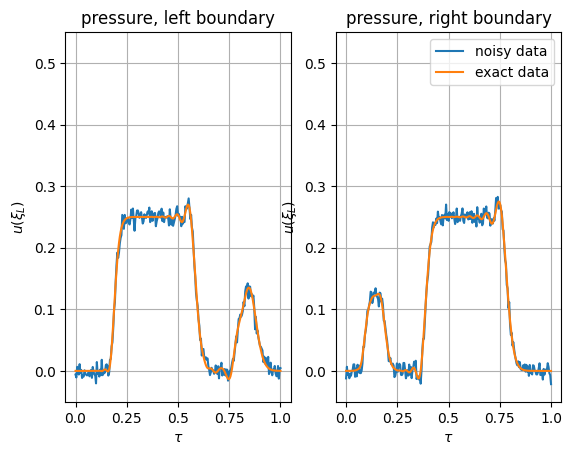

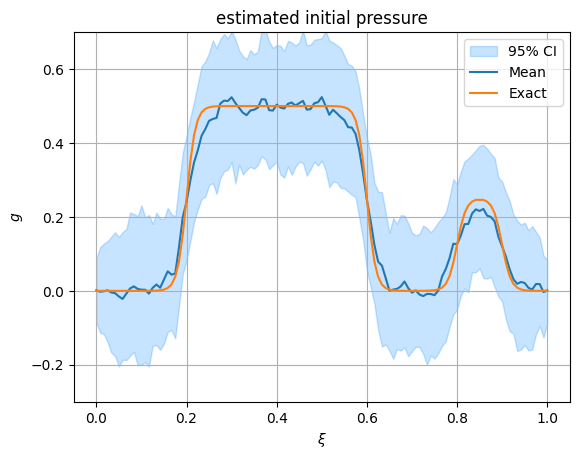

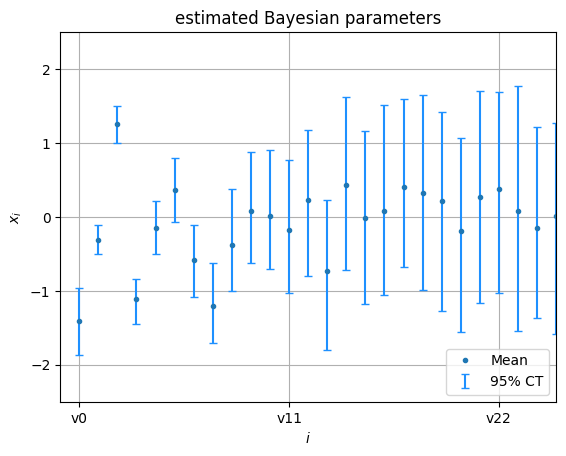

In [5]:
full_data = True #full data case
print("Running PAT for the full data case")
run_PAT(full_data, Ns=50000, Nb=0, Nt=100, seed=0)

Running PAT for the partial data case
 Sample 50000 / 50000

Average acceptance rate: 0.34872 MCMC scale: 0.056152224358036004 



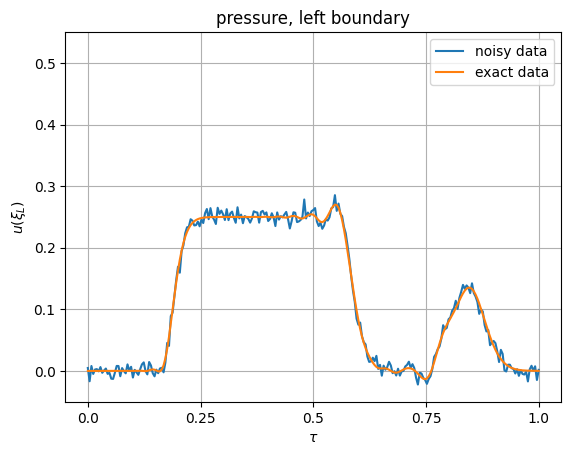

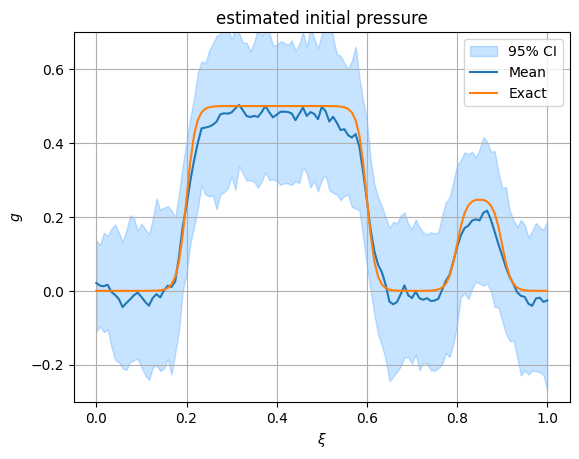

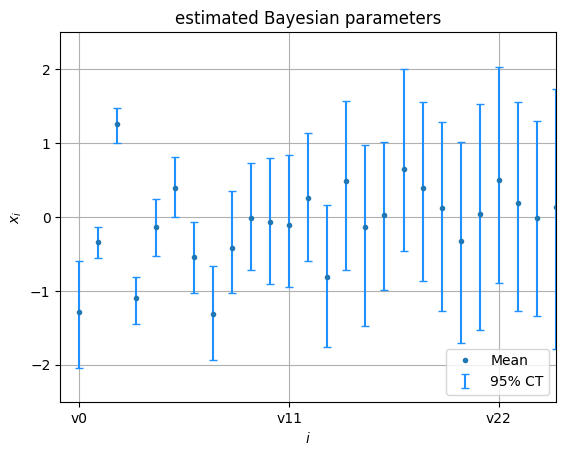

In [6]:
full_data = False #partial data case
print("Running PAT for the partial data case")
run_PAT(full_data, Ns=50000, Nb=0, Nt=100, seed=0)

Then we run the following code cells to generate the exact paper figures from the samples generated above, these figures are saved in `plots` folder.

Set up `matplotlib` parameters:

In [7]:
# Set up matplotlib parameters
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Load the observation data and the true parameters:

In [8]:
# Load observation data
obs_data_full = np.load( './obs/full_boundary_5per.npz' )
y_obs_full = obs_data_full['data'].reshape(251,2)
b_exact = obs_data_full['b_exact'].reshape(251,2)
obs_data_half = np.load( './obs/half_boundary_5per.npz' )
y_obs_half = obs_data_half['data'].reshape(251,1)

# Load true parameter
init_pressure_data = np.load( './obs/init_pressure.npz' )
g_true = init_pressure_data['init_pressure']

Load the samples:

In [9]:
# Load samples
print('loading ...')
print('data 1 ...')
data_full = np.load('./stat/samples_thinned_full.npz')
samples_full = data_full['samples']
print('data 2 ...')
data_half = np.load('./stat/samples_thinned_half.npz')
samples_half = data_half['samples']

loading ...
data 1 ...
data 2 ...


Create the domain geometry `domain_geometry` again (for plotting purposes):

In [10]:
mesh = UnitIntervalMesh(120)
parameter_space = FunctionSpace(mesh,'CG', 1)
G = create_domain_geometry(parameter_space)

Create Samples objects:

In [11]:
cuqi_samples_full = Samples(samples_full, geometry=G)
cuqi_samples_half = Samples(samples_half, geometry=G)

Create true `FEniCS` function and wrap it in `CUQIarray`

In [12]:
g_true_function = Function(parameter_space)
g_true_function.vector().set_local(g_true[::-1])
g_true_function = CUQIarray(g_true_function, is_par=False, geometry=G)

Create plot directory if it does not exists

In [13]:
if not os.path.exists('./plots'):
    os.makedirs('./plots')

Plot figure 10:

<Figure size 640x480 with 0 Axes>

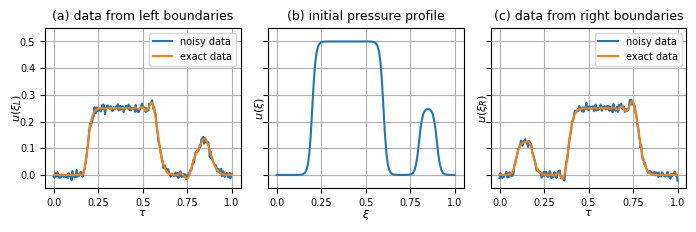

In [14]:

plt.figure()
plot_figure10(g_true, b_exact, y_obs_full)
plt.savefig('./plots/data.pdf',format='pdf')

Plot figure 11

<Figure size 640x480 with 0 Axes>

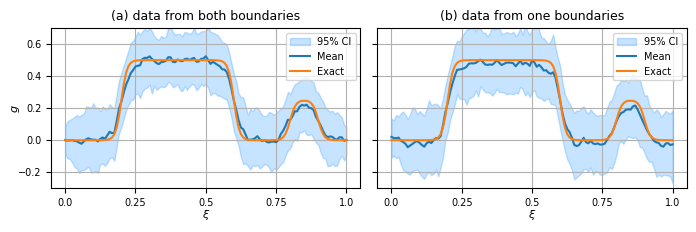

In [15]:
plt.figure()
plot_figure11(g_true_function, cuqi_samples_full, cuqi_samples_half)
plt.savefig('./plots/uq.pdf',format='pdf')

Plot figure 12

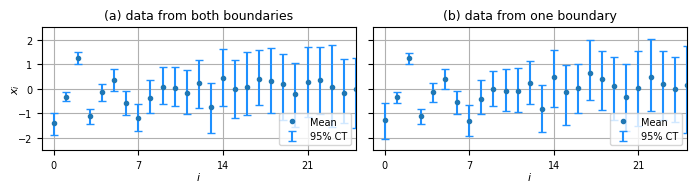

In [16]:
plot_figure12(cuqi_samples_full, cuqi_samples_half)
plt.savefig('./plots/params.pdf',format='pdf')